In [1]:
cp /kaggle/input/option-utils/* /kaggle/working/

In [2]:
import torch
import torch.autograd as tgrad
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import os
from european_utils import EuropeanOptionData, plot_solution
%matplotlib inline
from model_types import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
N_EPOCH = 25000
LEARNING_RATE = 1e-4
HIDDEN_LAYER = 3
HIDDEN_WIDTH = 128
N_sample = 10000
EXPERIMENT_NAME = "exp_gated2_correct-big2"
PHYSICS_PENALTY = 100
MODEL_TYPE = EuropeanCall_gated2
BVP1_PENALTY = 7
ERR_SAMPLING = False

experiment_dir = f"./{EXPERIMENT_NAME}"
os.makedirs(experiment_dir, exist_ok=True)

In [5]:
import logging
from datetime import datetime
logger = logging.getLogger()
current_date = datetime.now().strftime("%Y-%m-%d")
log_file_name = f"{experiment_dir}/{EXPERIMENT_NAME}_log_{current_date}.log"
fhandler = logging.FileHandler(filename=log_file_name, mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [6]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)
logging.info(f"Running on device={DEVICE}")

### Parameters for the experiment

In [7]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"PHYSICS_PENALTY: {PHYSICS_PENALTY}")
logging.info(f"BVP1_PENALTY: {BVP1_PENALTY}")
logging.info(f"ERR_SAMPLING: {ERR_SAMPLING}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

## Declare parameters for European Call

In [8]:
K = 40
r = 0.05
sigma = 0.2
T = 1
S_range = [0, 160]
t_range = [0, T]

In [9]:
euro_call_data = EuropeanOptionData(t_range,S_range,K,r,sigma)

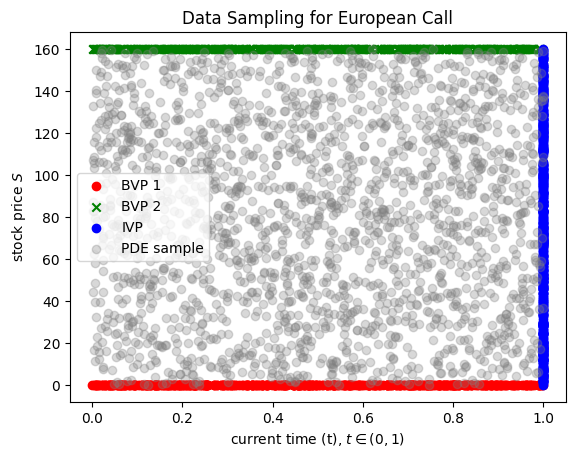

In [10]:
bvp_x1,bvp_y1,bvp_x2,bvp_y2 = euro_call_data.get_bvp_data(500,1,1)
ivp_x1,ivp_y1 = euro_call_data.get_ivp_data(500,1)
diff_x1,diff_y1 = euro_call_data.get_diff_data(2000)
plt.scatter(bvp_x1[:,0],bvp_x1[:,1], label= "BVP 1", color = "red",marker="o")
plt.scatter(bvp_x2[:,0],bvp_x2[:,1], label= "BVP 2", color = "green",marker="x")
plt.scatter(ivp_x1[:,0],ivp_x1[:,1], label= "IVP", color = "blue")
plt.scatter(diff_x1[:,0],diff_x1[:,1], label= "PDE sample", color = "grey", alpha = 0.3)
plt.xlabel(f"current time (t), $t \in (0,1)$")
plt.ylabel("stock price $S$")
plt.title("Data Sampling for European Call")
plt.legend()

### Train Pytorch Model

In [11]:
model = MODEL_TYPE(2,1,HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
logging.info(f"Model parameters : {sum(p.numel() for p in model.parameters())/10**3:.2f}K")

In [12]:
# N_sample = 500
physics_lr = PHYSICS_PENALTY
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

loss_history={
    "total_loss":[],"loss_ivp_bvp":[],"loss_BS":[],\
    "loss_bvp1":[],"loss_bvp2":[],"loss_ivp":[],
}

* BVP 1 $S = S_{min}$: 0

* BVP2 ($S = S_{max}$): $S_{max} - K \cdot e^{-rt}$

* IVP (t=T): $max(S-K,0)$ *call this initial but corresponds to expiry*

In [13]:
def get_sample_rt(l1,l2,l3):
    t = l1+l2+l3
    l1 = max(l1*3/t,0.25)
    l2 = max(l2*3/t,0.25)
    l3 = max(l3*3/t,0.25)
    return (l1,l2,l3)

In [14]:
r_ivp,r_bvp1,r_bvp2 = 1,1,1
for i in range(N_EPOCH):
    model.train();
    # Get IVP data
    ivp_x_tensor,ivp_y_tensor = euro_call_data.get_ivp_data_tensor(N_sample,r_ivp)
    ivp_x_tensor = ivp_x_tensor.to(DEVICE)
    ivp_y_tensor = ivp_y_tensor.to(DEVICE)
    # ivp_x_tensor = euro_call_data.normalize(ivp_x_tensor)
    ivp_y_pred = model(ivp_x_tensor)
    mse_ivp = nn.MSELoss()(ivp_y_tensor, ivp_y_pred)

    # Get BVP data
    bvp_x1_tensor,bvp_y1_tensor,bvp_x2_tensor,bvp_y2_tensor = euro_call_data.get_bvp_data_tensor(N_sample,r_bvp1,r_bvp2)
    bvp_x1_tensor,bvp_y1_tensor = bvp_x1_tensor.to(DEVICE),bvp_y1_tensor.to(DEVICE)
    bvp_x2_tensor,bvp_y2_tensor = bvp_x2_tensor.to(DEVICE),bvp_y2_tensor.to(DEVICE)
    # bvp_x1_tensor = euro_call_data.normalize(bvp_x1_tensor)
    bvp_y1_pred = model(bvp_x1_tensor)
    mse_bvp1 = nn.MSELoss()(bvp_y1_tensor, bvp_y1_pred)
    # bvp_x2_tensor = euro_call_data.normalize(bvp_x2_tensor)
    bvp_y2_pred = model(bvp_x2_tensor)
    mse_bvp2 = nn.MSELoss()(bvp_y2_tensor, bvp_y2_pred)

    # Aggregate the "data loss"
    loss1 = mse_ivp + BVP1_PENALTY*mse_bvp1 + mse_bvp2

    # Compute the "Black-Scholes loss"
    X1,y1 = euro_call_data.get_diff_data(N_sample)
    X1 = torch.from_numpy(X1).float().requires_grad_().to(DEVICE)
    y1 = torch.from_numpy(y1).float().to(DEVICE)
    y1_hat = model(X1)
    grads = torch.autograd.grad(y1_hat, X1, grad_outputs=torch.ones(y1_hat.shape).to(DEVICE), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = torch.autograd.grad(dVdS, X1, grad_outputs=torch.ones(dVdS.shape).to(DEVICE), create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = X1[:, 1].view(-1, 1)
    bs_pde = dVdt + (0.5 * ((sigma * S1) ** 2) * d2VdS2) + (r * S1 * dVdS) - (r * y1_hat)
    loss2 = physics_lr * nn.MSELoss()(bs_pde, torch.zeros_like(bs_pde))

    # Backpropagate joint loss
    loss = loss1 + loss2
    loss_history["total_loss"].append(loss.item())
    loss_history["loss_ivp_bvp"].append(loss1.item())
    loss_history["loss_BS"].append(loss2.item())
    loss_history["loss_ivp"].append(mse_ivp.item())
    loss_history["loss_bvp1"].append(mse_bvp1.item())
    loss_history["loss_bvp2"].append(mse_bvp2.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #normalise the ratios
    if ERR_SAMPLING:
      r_ivp,r_bvp1,r_bvp2 = get_sample_rt(mse_ivp.item(),mse_bvp1.item(),mse_bvp2.item())
    # Plot the result as training progresses
    if (i + 1) % 500 == 0:
        logging.info(f"Epoch {i+1}, Loss: {loss.item():.4f}")
        print(f"Epoch {i+1}, Loss: {loss.item():.4f}")
    if (i+1) % 1000 == 0:
      plot_solution(model, euro_call_data, i+1, experiment_dir)


Epoch 500, Loss: 7707.5493
Epoch 1000, Loss: 5025.5435
Epoch 1500, Loss: 1865.8643
Epoch 2000, Loss: 782.6552
Epoch 2500, Loss: 328.2078
Epoch 3000, Loss: 157.3598
Epoch 3500, Loss: 84.8680
Epoch 4000, Loss: 49.6224
Epoch 4500, Loss: 21.6331
Epoch 5000, Loss: 4.5222
Epoch 5500, Loss: 1.3449
Epoch 6000, Loss: 0.7936
Epoch 6500, Loss: 1.7996
Epoch 7000, Loss: 0.4358
Epoch 7500, Loss: 0.7493
Epoch 8000, Loss: 0.3181
Epoch 8500, Loss: 0.2749
Epoch 9000, Loss: 0.8381
Epoch 9500, Loss: 0.2724
Epoch 10000, Loss: 0.3026
Epoch 10500, Loss: 0.2895
Epoch 11000, Loss: 0.2815
Epoch 11500, Loss: 0.4195
Epoch 12000, Loss: 0.1961
Epoch 12500, Loss: 0.2182
Epoch 13000, Loss: 0.2638
Epoch 13500, Loss: 0.2982
Epoch 14000, Loss: 0.2088
Epoch 14500, Loss: 0.2061
Epoch 15000, Loss: 0.2550
Epoch 15500, Loss: 0.1799
Epoch 16000, Loss: 0.4140
Epoch 16500, Loss: 0.2100
Epoch 17000, Loss: 0.1708
Epoch 17500, Loss: 0.1615
Epoch 18000, Loss: 0.4844
Epoch 18500, Loss: 0.9729
Epoch 19000, Loss: 0.1599
Epoch 19500, L

### Training Curve

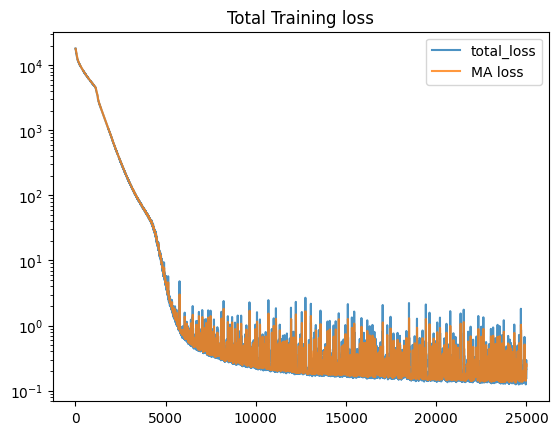

In [15]:
loss_df = pd.DataFrame.from_dict(loss_history)
ax = loss_df[["total_loss"]].plot(logy=True,alpha=0.8)
loss_df[["total_loss"]].rename(columns={"total_loss":"MA loss"}).rolling(10).mean().plot(logy=True,alpha=0.8, label="MA", ax = ax)
plt.title("Total Training loss")
plt.savefig(experiment_dir+"/total_loss.jpg")

In [16]:
tail_result = loss_df.rolling(50).mean().tail(1)
logging.info(f"Loss results")
logging.info(f"{tail_result}")


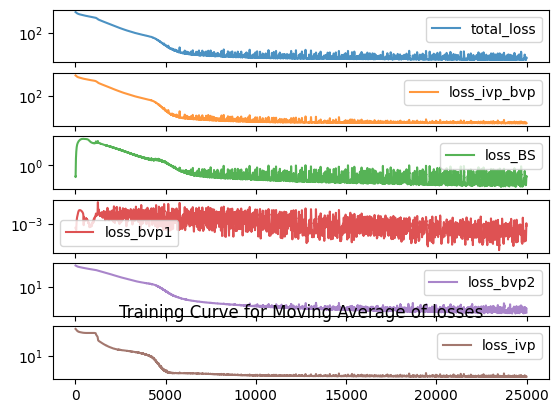

In [17]:
loss_df.rolling(10).mean().plot(logy=True,alpha=0.8, subplots = True)
plt.title("Training Curve for Moving Average of losses")
plt.savefig(experiment_dir+"/ivp_bs_loss.jpg")

## Visualisation of Results

In [18]:
%matplotlib inline

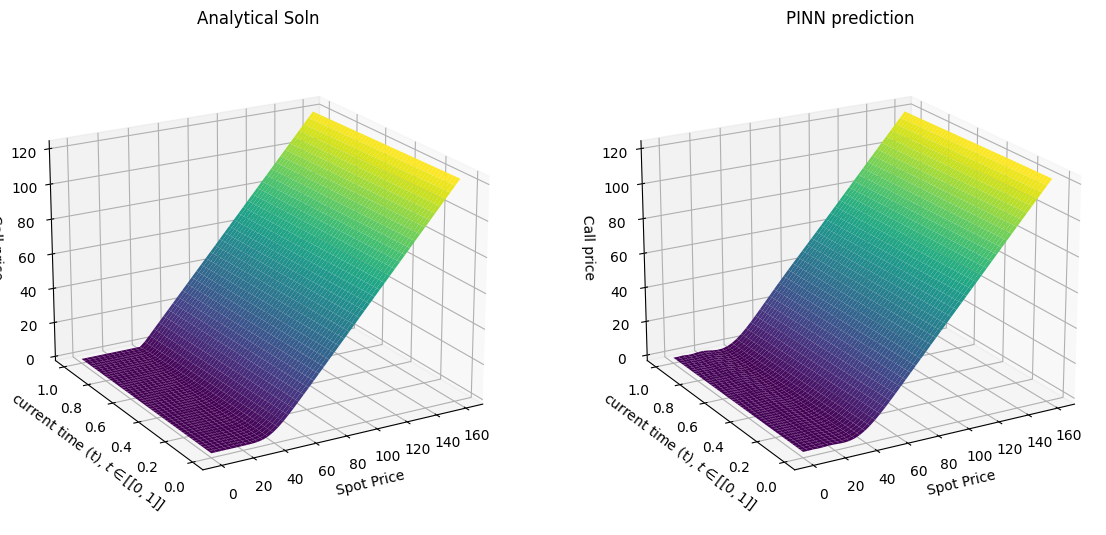

In [19]:
s = np.linspace(S_range[0], S_range[1], 50)
t = np.linspace(t_range[0], t_range[1], 50)
s_grid, t_grid = np.meshgrid(s, t)
s_flat = s_grid.flatten()
t_flat = t_grid.flatten()
# Create a 2D tensor from the flattened arrays
X_test = torch.tensor(np.column_stack((t_flat, s_flat)), dtype=torch.float)
# X_test_norm = euro_call_data.normalize(X_test)
y_analytical_test = euro_call_data.get_analytical_soln(X_test[:,1],X_test[:,0])
model.eval();
with torch.no_grad():
  y_pinn_test = model(X_test)
# Create the 3D plot
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(s_grid, t_grid, y_analytical_test.cpu().numpy().reshape(s_grid.shape), cmap = "viridis")
ax.set_title("Analytical Soln")
ax.set_xlabel("Spot Price")
ax.set_ylabel(f"current time (t), $t \in {[t_range]}$")
ax.set_zlabel("Call price")
ax.view_init(elev=20, azim=-120)
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(s_grid, t_grid, y_pinn_test.cpu().numpy().reshape(s_grid.shape), cmap = "viridis")
ax.set_title("PINN prediction")
ax.set_xlabel("Spot Price")
ax.set_ylabel(f"current time (t), $t \in {[t_range]}$")
ax.set_zlabel("Call price")
ax.view_init(elev=20, azim=-120)
plt.savefig(experiment_dir+f"/true_vs_pred_final.jpg")

In [20]:
%matplotlib inline

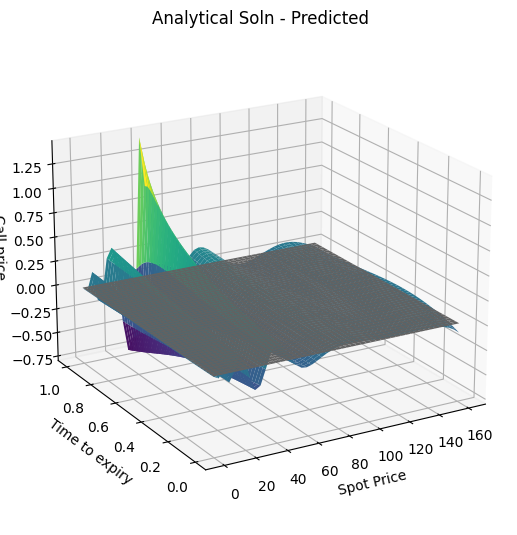

In [21]:
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(121, projection='3d')
err = y_pinn_test.cpu().numpy().reshape(s_grid.shape) - y_analytical_test.cpu().numpy().reshape(s_grid.shape)
ax.plot_surface(s_grid, t_grid, err, cmap = "viridis")
ax.plot_surface(s_grid, t_grid, np.zeros(err.shape), color = "grey")
ax.set_title("Analytical Soln - Predicted")
ax.set_xlabel("Spot Price")
ax.set_ylabel("Time to expiry")
ax.set_zlabel("Call price")
ax.view_init(elev=20, azim=-120)
plt.savefig(experiment_dir+"/error_surface.jpg")
plt.show()

In [22]:
err = (y_pinn_test-y_analytical_test.reshape(y_analytical_test.shape[0],-1)).cpu().numpy()
loss_mse = np.square(err).sum()/(len(err))
print(f"MSE net: {loss_mse:.3f}")
logging.info(f"MSE net: {loss_mse:.3f}")

MSE net: 0.030


### Corealtion

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

Coef: 1.000


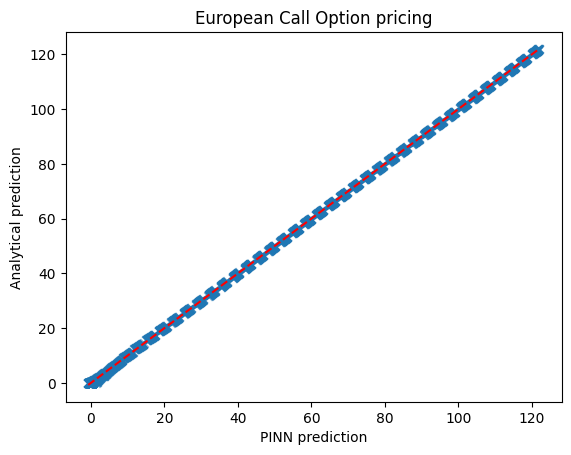

In [24]:
plt.scatter(x= y_pinn_test.cpu().numpy(), y = y_analytical_test.cpu().numpy(), marker = "x", alpha = 0.5)
plt.plot([min(y_pinn_test.cpu().numpy().min(), y_analytical_test.cpu().numpy().min()),\
          max(y_pinn_test.cpu().numpy().max(), y_analytical_test.cpu().numpy().max())],
         [min(y_pinn_test.cpu().numpy().min(), y_analytical_test.cpu().numpy().min()),\
          max(y_pinn_test.cpu().numpy().max(), y_analytical_test.cpu().numpy().max())],
         linestyle='--', color='red', label='Diagonal line')
plt.xlabel("PINN prediction")
plt.ylabel("Analytical prediction")
plt.title("European Call Option pricing")
plt.savefig(experiment_dir+"/true_vs_pred_coef.jpg")
coef_res = np.corrcoef(y_pinn_test.cpu().numpy().reshape(y_pinn_test.shape[0],),y_analytical_test.cpu().numpy())
logging.info(f"Coef: {coef_res[0,1]:.3f}")
print(f"Coef: {coef_res[0,1]:.3f}")

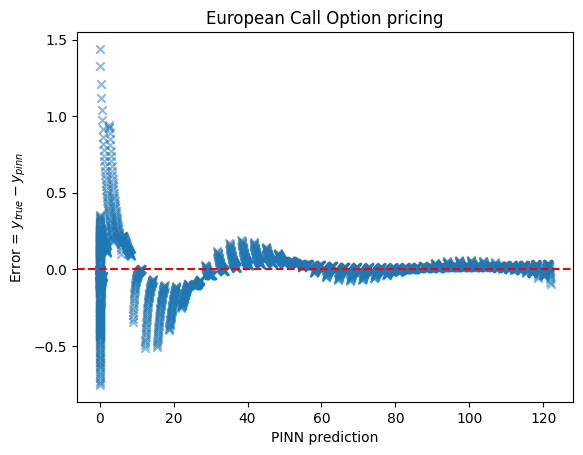

In [25]:
plt.scatter(x= y_analytical_test.cpu().numpy(), y=err, marker = "x", alpha = 0.5)
plt.axhline(0,linestyle="--",color="r")
plt.xlabel("PINN prediction")
plt.ylabel("Error = $y_{true} - y_{pinn}$")
plt.title("European Call Option pricing")
plt.savefig(experiment_dir+"/true_vs_pred_error1.jpg")

In [26]:
torch.save(model.state_dict(), f"{experiment_dir}/model_path")

In [27]:
!zip -r ./{experiment_dir}.zip $experiment_dir

  adding: exp_gated2_correct-big2/ (stored 0%)
  adding: exp_gated2_correct-big2/true_vs_pred_11000.jpg (deflated 14%)
  adding: exp_gated2_correct-big2/true_vs_pred_20000.jpg (deflated 14%)
  adding: exp_gated2_correct-big2/true_vs_pred_17000.jpg (deflated 14%)
  adding: exp_gated2_correct-big2/true_vs_pred_8000.jpg (deflated 14%)
  adding: exp_gated2_correct-big2/exp_gated2_correct-big2_log_2023-12-02.log (deflated 75%)
  adding: exp_gated2_correct-big2/true_vs_pred_final.jpg (deflated 14%)
  adding: exp_gated2_correct-big2/true_vs_pred_error1.jpg (deflated 27%)
  adding: exp_gated2_correct-big2/true_vs_pred_15000.jpg (deflated 14%)
  adding: exp_gated2_correct-big2/true_vs_pred_25000.jpg (deflated 14%)
  adding: exp_gated2_correct-big2/true_vs_pred_2000.jpg (deflated 14%)
  adding: exp_gated2_correct-big2/ivp_bs_loss.jpg (deflated 23%)
  adding: exp_gated2_correct-big2/true_vs_pred_7000.jpg (deflated 14%)
  adding: exp_gated2_correct-big2/true_vs_pred_18000.jpg (deflated 14%)
  addi